In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#database connection settings
import psycopg2

db_name = "traviato_development"
db_host = "localhost"
db_port = "5432"
db_user = "lievgarcia"
db_pwd = "traviato81"

conn = psycopg2.connect(database=db_name, user=db_user, password=db_pwd, host=db_host, port=db_port)

In [3]:
######################## libraries ########################

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np

import sys
sys.path.append('../../')

from utils.utility_functions import label_top
from utils.utility_functions import get_last_name
from utils.utility_functions import make_dash_zero
from utils.utility_functions import make_dash_zero_float

# from utils.utility_functions import shorten_opera_name

##################### CHARTING OPTIONS #####################

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})

rc('text', usetex=False)
# rc.rcParams['text.usetex']=True
# rc.rcParams['text.latex.unicode']=True

from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45', '#8a170f']


##################### SOURCES OPTIONS #####################

archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper', 
                    'Chicago Lyric Opera','San Francisco Opera','Czech National Theatre','Glyndebourne','Salzburg Festival',
                    'Sweden Opera House','National Opera de Paris','Opera Comique']
commercial_sources_world = ['bachtrack.com','operabase.com','operacritic.com']
commercial_sources_uk = ['Concert-Diary','U.K. Theatre Web']
government_sources = ['National Central Opera Service Reports', 'Opera America']

##############################################################################

In [4]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 'date_start', 'date_end', 'premiere_date', 'performance_count']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "ORDER BY s.id, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)

In [5]:
#################### top composers HHI ####################

sources = archival_sources
# print(sources)
num_sources = len(sources)

o_df = mdf.copy()
# o_df = o_df[o_df['source_name']=='National Opera de Paris']
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2019]

c_df = o_df.groupby(['source_name', 'composer', 'decade']).agg({'performance_count': np.sum })
c_df['perc'] = c_df.groupby(level = ['source_name', 'decade']).transform(lambda x: x/x.sum())
c_df['perc'] = c_df['perc']*100
c_df['hhi'] = c_df.apply(lambda x: x['perc']**2, axis=1)
c_df = c_df.reset_index(level=['source_name', 'composer', 'decade'])

c_df = c_df.groupby(['source_name', 'decade']).agg({'hhi': np.sum })
c_df = c_df.reset_index(level=['source_name', 'decade'])
d_df = c_df.pivot(index='decade', columns='source_name', values=['hhi'])

d_df = d_df.fillna(value=0)
# d_df = d_df.round()

decades = d_df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades]

print('r'*len(decades))
print('\\textbf{Decade} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in d_df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values ]
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")

###############################################################

rrrrrrrrrrrrr
\textbf{Decade} & \textbf{Chicago Lyric Opera & \textbf{Czech National Theatre & \textbf{Glyndebourne & \textbf{Metropolitan Opera & \textbf{National Opera de Paris & \textbf{Opera Comique & \textbf{Opera Scotland & \textbf{Royal Opera House & \textbf{Salzburg Festival & \textbf{San Francisco Opera & \textbf{Sweden Opera House & \textbf{Teatro alla Scala & \textbf{Wiener Staatsoper \\ \midrule 
1760 & - & - & - & - & - & 10000 & - & - & - & - & - & - & - \\
1770 & - & - & - & - & - & 3008 & - & - & - & - & 1187 & - & - \\
1780 & - & - & - & - & - & - & - & - & - & - & 1704 & - & - \\
1790 & - & - & - & - & - & 5000 & - & - & - & - & 1218 & - & - \\
1800 & - & - & - & - & - & 795 & - & - & - & - & 884 & - & - \\
1810 & - & - & - & - & - & 637 & - & - & - & - & 891 & - & - \\
1820 & - & - & - & - & - & 541 & - & - & - & - & 595 & - & - \\
1830 & - & - & - & - & - & 775 & - & - & - & - & 523 & - & - \\
1840 & - & - & - & - & - & 2165 & - & - & - & - & 946 & - & - \\
1850 & -

In [10]:
#################### Works HHI ####################

sources = archival_sources
# print(sources)
num_sources = len(sources)

o_df = mdf.copy()
# o_df = o_df[o_df['source_name']=='National Opera de Paris']
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2019]

c_df = o_df.groupby(['source_name', 'work', 'decade']).agg({'performance_count': np.sum })
c_df['perc'] = c_df.groupby(level = ['source_name', 'decade']).transform(lambda x: x/x.sum())
c_df['perc'] = c_df['perc']*100
c_df['hhi'] = c_df.apply(lambda x: x['perc']**2, axis=1)
c_df = c_df.reset_index(level=['source_name', 'work', 'decade'])

c_df = c_df.groupby(['source_name', 'decade']).agg({'hhi': np.sum })
c_df = c_df.reset_index(level=['source_name', 'decade'])
d_df = c_df.pivot(index='decade', columns='source_name', values=['hhi'])

d_df = d_df.fillna(value=0)
# d_df = d_df.round()

decades = d_df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades]

print('r'*len(decades))
print('\\textbf{Decade} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in d_df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values ]
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")

###############################################################

rrrrrrrrrrrrr
\textbf{Decade} & \textbf{Chicago Lyric Opera & \textbf{Czech National Theatre & \textbf{Glyndebourne & \textbf{Metropolitan Opera & \textbf{National Opera de Paris & \textbf{Opera Comique & \textbf{Opera Scotland & \textbf{Royal Opera House & \textbf{Salzburg Festival & \textbf{San Francisco Opera & \textbf{Sweden Opera House & \textbf{Teatro alla Scala & \textbf{Wiener Staatsoper \\ \midrule 
1760 & - & - & - & - & - & 10000 & - & - & - & - & - & - & - \\
1770 & - & - & - & - & - & 1093 & - & - & - & - & 921 & - & - \\
1780 & - & - & - & - & - & - & - & - & - & - & 594 & - & - \\
1790 & - & - & - & - & - & 5000 & - & - & - & - & 404 & - & - \\
1800 & - & - & - & - & - & 726 & - & - & - & - & 209 & - & - \\
1810 & - & - & - & - & - & 154 & - & - & - & - & 260 & - & - \\
1820 & - & - & - & - & - & 134 & - & - & - & - & 243 & - & - \\
1830 & - & - & - & - & - & 239 & - & - & - & - & 233 & - & - \\
1840 & - & - & - & - & - & 1167 & - & - & - & - & 398 & - & - \\
1850 & - & 

In [47]:
#################### top composers share of repertoire ####################

sources = archival_sources
# print(sources)
num_sources = len(sources)

o_df = mdf.copy()
# o_df = o_df[o_df['source_name']=='National Opera de Paris']
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2019]
o_df = o_df[o_df['decade'] >= 1960]

c_df = o_df.groupby(['source_name', 'composer']).agg({'performance_count': np.sum })
c_df['perc'] = c_df.groupby(level=['source_name']).transform(lambda x: x/x.sum())
c_df['perc'] = c_df['perc']*100
c_df['hhi_composer'] = c_df.apply(lambda x: x['perc']**2, axis=1)
c_df = c_df.reset_index(level=['source_name', 'composer'])
c_df = c_df.groupby(['source_name']).agg({'hhi_composer': np.sum })

###############################################################

o_df = mdf.copy()
# o_df = o_df[o_df['source_name']=='National Opera de Paris']
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2019]
o_df = o_df[o_df['decade'] >= 1960]

w_df = o_df.groupby(['source_name', 'work']).agg({'performance_count': np.sum })
w_df['perc'] = w_df.groupby(level=['source_name']).transform(lambda x: x/x.sum())
w_df['perc'] = w_df['perc']*100
w_df['hhi_work'] = w_df.apply(lambda x: x['perc']**2, axis=1)
w_df = w_df.reset_index(level=['source_name', 'work'])
w_df = w_df.groupby(['source_name']).agg({'hhi_work': np.sum })

df = c_df.join(w_df, how='outer')
df = df.round(0)
# df['perc'] = df['hhi_work']/df['hhi_composer']

df
# df = pd.DataFrame(data=a)
# df.corr()
###############################################################

,hhi_composer,hhi_work
source_name,,
Chicago Lyric Opera,668.0,133.0
Czech National Theatre,913.0,228.0
Glyndebourne,1187.0,257.0
Metropolitan Opera,1052.0,185.0
National Opera de Paris,605.0,117.0
Opera Comique,984.0,250.0
Opera Scotland,532.0,116.0
Royal Opera House,900.0,137.0
Salzburg Festival,2159.0,299.0


In [51]:
#################### top composers share of repertoire ####################

sources = archival_sources
# print(sources)
num_sources = len(sources)

o_df = mdf.copy()
# o_df = o_df[o_df['source_name']=='Metropolitan Opera']
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2019]
o_df = o_df[o_df['decade'] >= 1960]
o_df['top_composer'] = 'No'

for source in sources:
#     print(source)
    c_df = o_df[o_df['source_name']==source]    
    c_df = c_df.groupby(['composer']).agg({'performance_count': np.sum })
    c_df = c_df.reset_index(level=['composer'])

    y_df = c_df.groupby(['composer'])
    y_df = y_df.agg({'performance_count': np.sum })    
    y_df = y_df.sort_values(by=['performance_count'], ascending=False)    
    top = y_df.head(5)
    for composer in list(top.index):
        o_df.loc[(o_df['source_name']==source)&(o_df['composer']==composer), 'top_composer']='Yes'

o_df = o_df[o_df['decade'] >= 1770]
c_df = o_df.groupby(['source_name', 'top_composer']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['source_name']).transform(lambda x: x/x.sum())
c_df = c_df.reset_index(level=['top_composer'])
c_df = c_df[c_df['top_composer']=='Yes']

c_df['performance_count']=c_df['performance_count']*100
cs_df = c_df.drop(columns=['top_composer'])


# df = cs_df.join(df, how='outer')
df

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values ]
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")

###############################################################

Chicago Lyric Opera & 50 & 668 & 133 \\
Czech National Theatre & 61 & 913 & 228 \\
Glyndebourne & 54 & 1187 & 257 \\
Metropolitan Opera & 61 & 1052 & 185 \\
National Opera de Paris & 46 & 605 & 117 \\
Opera Comique & 58 & 984 & 250 \\
Opera Scotland & 43 & 532 & 116 \\
Royal Opera House & 60 & 900 & 137 \\
Salzburg Festival & 67 & 2159 & 299 \\
San Francisco Opera & 52 & 738 & 123 \\
Sweden Opera House & 46 & 570 & 146 \\
Teatro alla Scala & 49 & 655 & 83 \\
Wiener Staatsoper & 63 & 909 & 166 \\


In [58]:
c = df.corr()
c
for idx,row in c.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero_float(c) for c in values ]    
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")

c

performance_count & 1.0 & 0.7601535958907555 & 0.689437279220023 \\
hhi_composer & 0.7601535958907555 & 1.0 & 0.8217076511260877 \\
hhi_work & 0.689437279220023 & 0.8217076511260877 & 1.0 \\


,performance_count,hhi_composer,hhi_work
performance_count,1.000000,0.760154,0.689437
hhi_composer,0.760154,1.000000,0.821708
hhi_work,0.689437,0.821708,1.000000


In [52]:
df

,performance_count,hhi_composer,hhi_work
source_name,,,
Chicago Lyric Opera,50.506187,668.0,133.0
Czech National Theatre,61.444835,913.0,228.0
Glyndebourne,54.830040,1187.0,257.0
Metropolitan Opera,61.237972,1052.0,185.0
National Opera de Paris,46.886391,605.0,117.0
Opera Comique,58.320043,984.0,250.0
Opera Scotland,43.362735,532.0,116.0
Royal Opera House,60.235235,900.0,137.0
Salzburg Festival,67.198087,2159.0,299.0


In [4]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'theatre_category']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       CASE WHEN l.source_id = 1 then 'Professional' when opera_america_name IS NULL THEN 'Amateur' ELSE 'Professional' END as theatre_category " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN theatre_mapping tm ON l.theatre = tm.name " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE source_id IN (1, 6) AND w.uri != 'W1' " + \
        "ORDER BY s.id, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)

mdf.loc[mdf['theatre']=='New York City Opera', 'theatre_category'] = 'Professional'

In [73]:
o_df = mdf.copy()
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['year'] < 2019]
o_df = o_df[o_df['year'] > 1991]
o_df = o_df[o_df['theatre_category']=='Professional']
# o_df = o_df[o_df['country']=='United States']

top_df = o_df.groupby(['theatre']).agg({'performance_count': np.sum })
top_df = top_df.reset_index(level=['theatre'])
top_df = top_df.nlargest(60, 'performance_count')
top_25 = top_df.nlargest(10, 'performance_count')

top_df = top_df['theatre'].values.tolist()
top_25 = top_25['theatre'].values.tolist()

o_df = o_df[o_df['theatre'].isin(top_25)]

###############################################################
c_df = o_df.groupby(['theatre', 'composer']).agg({'performance_count': np.sum })
c_df['perc'] = c_df.groupby(level=['theatre']).transform(lambda x: x/x.sum())
c_df['perc'] = c_df['perc']*100
c_df['hhi_composer'] = c_df.apply(lambda x: x['perc']**2, axis=1)
c_df = c_df.reset_index(level=['theatre', 'composer'])
c_df = c_df.groupby(['theatre']).agg({'hhi_composer': np.sum })

###############################################################

w_df = o_df.groupby(['theatre', 'work']).agg({'performance_count': np.sum })
w_df['perc'] = w_df.groupby(level=['theatre']).transform(lambda x: x/x.sum())
w_df['perc'] = w_df['perc']*100
w_df['hhi_work'] = w_df.apply(lambda x: x['perc']**2, axis=1)
w_df = w_df.reset_index(level=['theatre', 'work'])
w_df = w_df.groupby(['theatre']).agg({'hhi_work': np.sum })

df = c_df.join(w_df, how='outer')
df = df.round(0)

df.sort_values(by='hhi_composer', ascending=False)

c = df.corr()
print(c)

y = df['hhi_composer'].tolist()
z = df['hhi_work'].tolist()
n = df.index.values

fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(z, y, color=colors[0])

ann = ['Metropolitan Opera', 'Lyric Opera of Chicago', 
       'Houston Grand Opera', 'Skylight Music Theatre', 
       'Sarasota Opera']

shift_up = ['Los Angeles Opera', 'San Francisco Opera']
shift_left = ['Canadian Opera Company']
shift_down = ['Seattle Opera', 'Glimmerglass Festival']

for i, txt in enumerate(n):
    if txt in ann:
        ax.annotate(txt, (z[i]+3, y[i]))
    elif txt in shift_up:
        ax.annotate(txt, (z[i]+3, y[i]+20))        
    elif txt in shift_left:
        ax.annotate(txt, (z[i]-30, y[i]+3))        
    elif txt in shift_down:
        ax.annotate(txt, (z[i], y[i]-20))        

        
plt.xlabel('HHI Work')
plt.ylabel('HHI Composer')

,hhi_composer,hhi_work
hhi_composer,1.000000,0.667896
hhi_work,0.667896,1.000000


Text(0,0.5,'HHI Composer')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


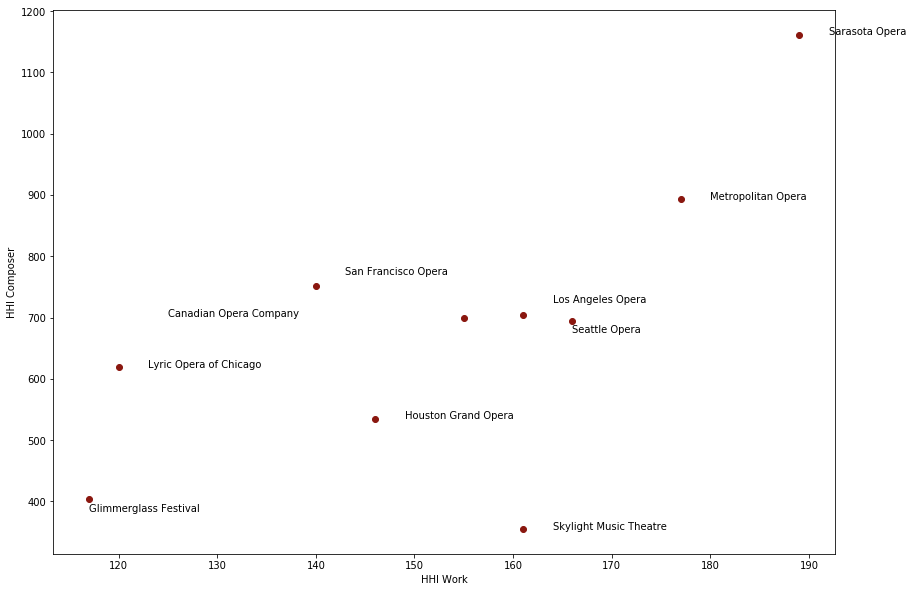

In [74]:
y = df['hhi_composer'].tolist()
z = df['hhi_work'].tolist()
n = df.index.values

fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(z, y, color=colors[0])

ann = ['Metropolitan Opera', 'Lyric Opera of Chicago', 
       'Houston Grand Opera', 'Skylight Music Theatre', 
       'Sarasota Opera']

shift_up = ['Los Angeles Opera', 'San Francisco Opera']
shift_left = ['Canadian Opera Company']
shift_down = ['Seattle Opera', 'Glimmerglass Festival']

for i, txt in enumerate(n):
    if txt in ann:
        ax.annotate(txt, (z[i]+3, y[i]))
    elif txt in shift_up:
        ax.annotate(txt, (z[i]+3, y[i]+20))        
    elif txt in shift_left:
        ax.annotate(txt, (z[i]-30, y[i]+3))        
    elif txt in shift_down:
        ax.annotate(txt, (z[i], y[i]-20))        

        
plt.xlabel('HHI Work')
plt.ylabel('HHI Composer')    

In [70]:
# top_25